# Check the Re-chunking of EOR sims

In [1]:
from pathlib import Path
from pyuvdata import UVData, __version__
from pyuvdata.uvdata import FastUVH5Meta
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import h5py

In [2]:
with open("h4c_freqs.yaml", 'r') as fl:
    freq_info = yaml.safe_load(fl)

In [3]:
freqs = np.arange(freq_info['start'], freq_info['end'], freq_info['delta'])

In [4]:
chnkpth = Path("outputs/eor/chunked")
rawpth = Path("outputs/eor/nt17280/")

In [5]:
chnkfiles = sorted(chnkpth.glob("*.uvh5"))

In [6]:
len(chnkfiles)

96

In [7]:
rawfiles0 = sorted(rawpth.glob("*_chunk0.uvh5"))

In [8]:
meta = FastUVH5Meta(rawfiles0[0])

In [9]:
zerofrqs = [FastUVH5Meta(fl) for fl in sorted(rawpth.glob("*fch0000*.uvh5"))]
raw_chunk_lst0 = [m.lsts[0] for m in zerofrqs]

In [10]:
lsts_all = [m.lsts for m in zerofrqs]

In [11]:
raw_chunk_lst0

[2.262659908325304e-07, 2.0943950788586005, 4.1887899452921795]

In [12]:
chans = np.nonzero((freqs >= 174e6) & (freqs < 194e6))[0]
chnslice = slice(chans[0], chans[-1]+1)

In [13]:
chnkmeta = FastUVH5Meta(chnkfiles[0])

## Check each file is exactly the same as chunked files

In [15]:
timechunk = 60

In [16]:
logfile = 'check_rechunk_eor.log'

In [26]:
np.nanmax(np.abs((thisd[mask] - rechunk_data[idx==chnk][:, :, i]).imag/thisd[mask].imag))

/tmp/ipykernel_51038/671037784.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmax(np.abs((thisd[mask] - rechunk_data[idx==chnk][:, :, i]).imag/thisd[mask].imag))


5.933788615914066e-08

In [ ]:
done = []
worst_comp = 0
worst_thing = None

for outerchunk, chunkfl in enumerate(chnkfiles[31:], start=32):
    print(f"DOING CHUNKED FILE: {outerchunk+1}/{len(chnkfiles)}: {chunkfl.name}")
    
    chnkmeta = FastUVH5Meta(chunkfl)
    ntimes = chnkmeta.Ntimes
    
    ntime_chunks = ntimes // timechunk
    
    for tchunk in range(ntime_chunks):
        print(f"  DOING SUBCHUNK {tchunk+1}/{ntime_chunks}")
        
        this = slice(tchunk*timechunk, (tchunk+1)*timechunk)
        idx = np.zeros(timechunk, dtype=int)
        
        idx[chnkmeta.lsts[this] >= raw_chunk_lst0[1]] = 1
        idx[chnkmeta.lsts[this] >= raw_chunk_lst0[2]] = 2
        req_idx = np.sort(np.unique(idx))

        with h5py.File(chunkfl, 'r') as fl:
            rechunk_data = fl['Data']['visdata'][this.start*chnkmeta.Nbls:this.stop*chnkmeta.Nbls, chnslice, :].reshape((timechunk, chnkmeta.Nbls, len(chans), 4))

        for chnk in req_idx:        
            print(f"    > chunk {chnk}")
            print("       ", end='')
            
            rawfls = sorted(rawpth.glob(f"*_chunk{chnk}.uvh5"))

            for i, pth in enumerate(rawfls[chans[0]:chans[-1]]):
                print(".",end='', flush=True)
                
                with h5py.File(pth, 'r') as fl:
                    thisd = fl['Data']['visdata'][()].reshape((meta.Ntimes, meta.Nbls, 4))

                thislst = lsts_all[chnk]
                mask = (thislst >= chnkmeta.lsts[this][0]) & (thislst <= chnkmeta.lsts[this][-1])
                badness = np.nanmax(np.abs(thisd[mask] - rechunk_data[idx==chnk][:, :, i])/np.abs(thisd[mask]))
                if badness > worst_comp:
                    worst_comp = badness
                    worst_thing = (outerchunk, tchunk, chnk, i)
                    print("New Worst: ", worst_thing, worst_comp)
                    
                if badness > 1e-7:
                    raise AssertionError(f'on chnkfl={chnkfl}, chnk={chnk}, chan={chans[i]}')
                
            done.append((outerchunk, tchunk, chnk))
            with open(logfile, 'a') as fl:
                fl.write('\n'+str(done))

DOING CHUNKED FILE: 33/96: zen.LST.2.0289452.eor.uvh5
  DOING SUBCHUNK 1/3
    > chunk 0
       .New Worst:  (32, 0, 0, 0) 5.916933348183008e-08
.New Worst:  (32, 0, 0, 1) 5.941543708087131e-08
........New Worst:  (32, 0, 0, 9) 5.947219525531974e-08
................................................................New Worst:  (32, 0, 0, 73) 5.949792115389131e-08
.New Worst:  (32, 0, 0, 74) 5.94983151923804e-08
.......................................New Worst:  (32, 0, 0, 113) 5.952901942360582e-08
................................................  DOING SUBCHUNK 2/3
    > chunk 0
       .......................................................................................New Worst:  (32, 1, 0, 86) 5.954961469745227e-08
...........................................................................  DOING SUBCHUNK 3/3
    > chunk 0
       ...................................................New Worst:  (32, 2, 0, 50) 5.955692837875206e-08
........................................................

## Check Delay Spectrum in each file

In [55]:
nt = chnkmeta.Ntimes
nbl = chnkmeta.Nbls

In [56]:
chnkmeta.pols

['xx', 'xy', 'yx', 'yy']

In [57]:
chunksize=60

In [58]:
with h5py.File(chnkfiles[0], 'r') as fl:
    vis = fl['Data']['visdata'][:chunksize*chnkmeta.Nbls, chnslice, :]

vis = vis[..., [0, 3]].reshape((chunksize, nbl, len(chans), 2)).transpose((0,1,3,2))  # now (nt, nbl, npol, nfreq)

In [59]:
# Remove the autos
vis = vis[:, 1:]

In [60]:
bh = np.blackman(len(chans))

In [61]:
dspec = np.fft.fftshift(np.abs(np.fft.fft(vis*bh, axis=-1))**2, axes=(-1,))

In [62]:
k = np.fft.fftshift(np.fft.fftfreq(len(chans)))

In [63]:
# Average over times
dspecavg = np.mean(dspec, axis=0)
dspecavgxx = dspecavg[:, 0]
dspecavgyy = dspecavg[:, 1]

In [64]:
# Get mean of high-k power
highk_meanxx = np.mean(dspecavgxx[:, -30:], axis=1)

In [65]:
uv = chnkmeta.uvw_array.reshape((nt, nbl, 3))[0, :, :2]

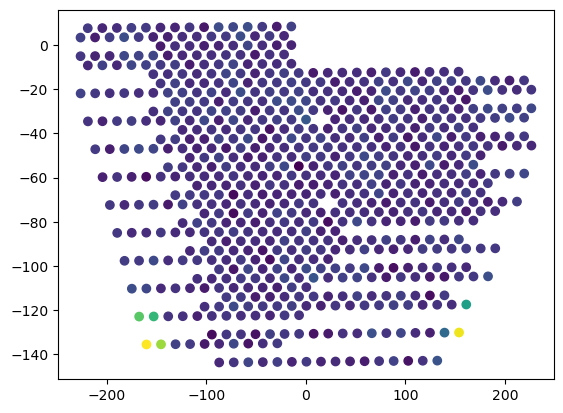

In [66]:
plt.scatter(uv[1:, 0], uv[1:, 1], c=np.log10(highk_meanxx))

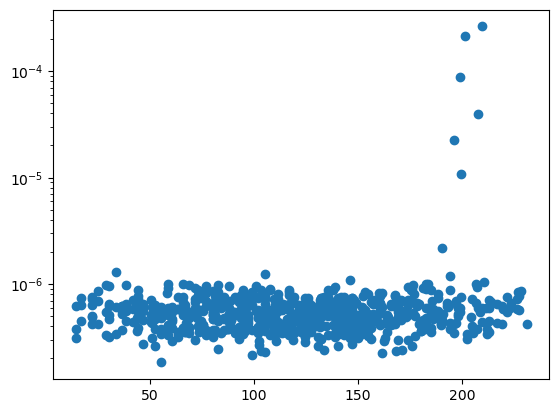

In [67]:
plt.scatter(np.sqrt(uv[1:, 0]**2 + uv[1:, 1]**2), highk_meanxx)
plt.yscale('log')

In [68]:
badbls = np.argwhere(highk_meanxx > 5e-6)[:, 0]

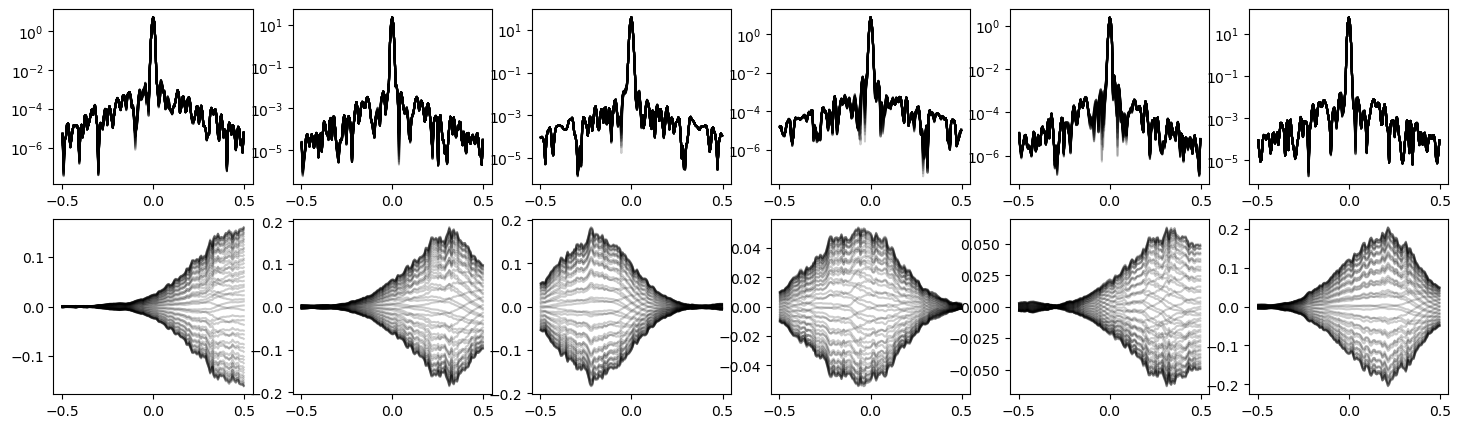

In [69]:
fig, ax = plt.subplots(2, len(badbls), figsize=(3*len(badbls), 5))
for j, bl in enumerate(badbls):
    for t in range(chunksize):
        ax[0, j].plot(k, dspec[t, bl, 0], color='k', alpha=0.2)
        ax[1, j].plot(k, vis[t, bl, 0].real, color='k', alpha=0.2)
    ax[0, j].set_yscale('log')

In [66]:
chnkmeta.uvw_array[292]

array([ 153.88156246, -130.14451427,    1.32142995])

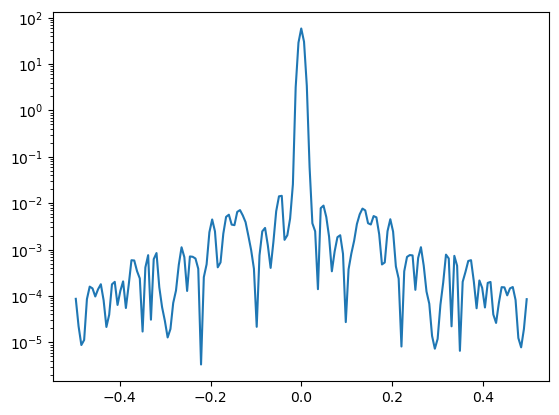

In [65]:
plt.plot(k, np.fft.fftshift(dspecavg[292,:,0]))
plt.yscale('log')

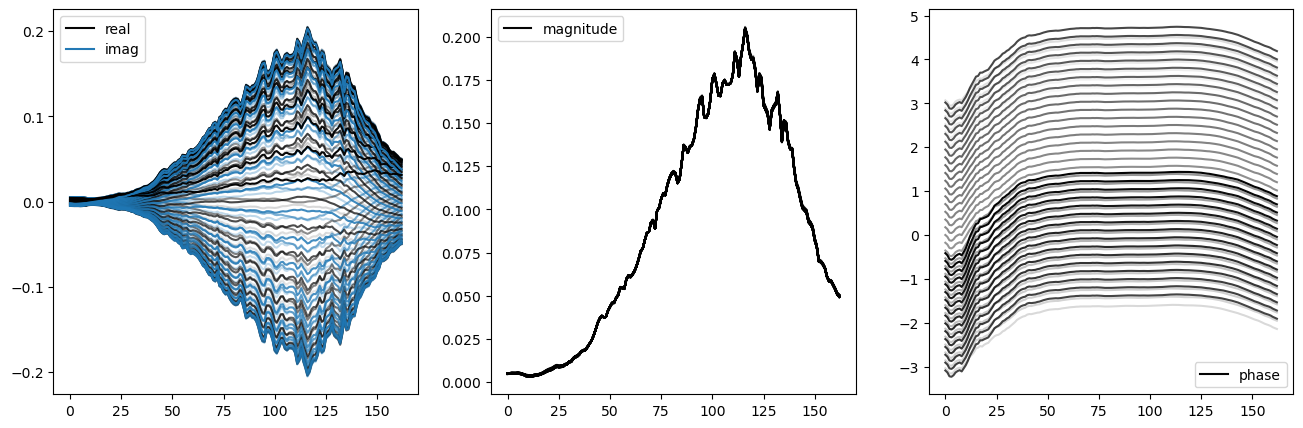

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    ax[0].plot(ddd[292, :, 0].real, color='k', alpha=i*(1./chunksize), label='real' if i==59 else None)
    ax[0].plot(ddd[292, :, 0].imag, color='C0', alpha=i*(1./chunksize), label='imag' if i==59 else None)
    ax[1].plot(np.abs(ddd[292, :, 0]), color='k', alpha=i*(1./chunksize), label='magnitude' if i==59 else None)
    ax[2].plot(np.unwrap(np.angle(ddd[292, :, 0])), color='k', alpha=i*(1./chunksize), label='phase' if i==59 else None)
    
ax[0].legend()
ax[1].legend()
ax[2].legend()


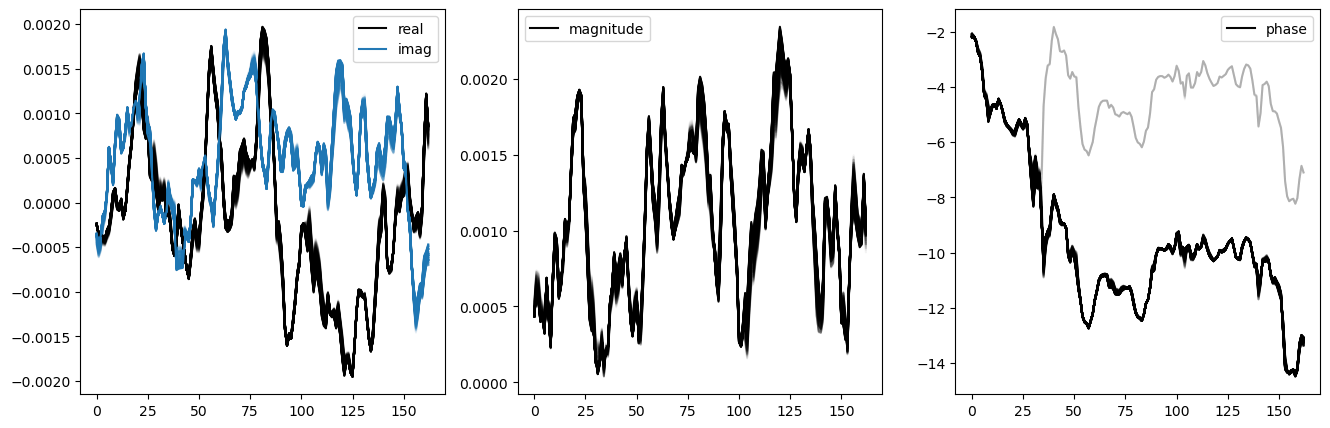

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    ax[0].plot(ddd[291, :, 0].real, color='k', alpha=i*(1./chunksize), label='real' if i==59 else None)
    ax[0].plot(ddd[291, :, 0].imag, color='C0', alpha=i*(1./chunksize), label='imag' if i==59 else None)
    ax[1].plot(np.abs(ddd[291, :, 0]), color='k', alpha=i*(1./chunksize), label='magnitude' if i==59 else None)
    ax[2].plot(np.unwrap(np.angle(ddd[291, :, 0])), color='k', alpha=i*(1./chunksize), label='phase' if i==59 else None)
    
ax[0].legend()
ax[1].legend()
ax[2].legend()


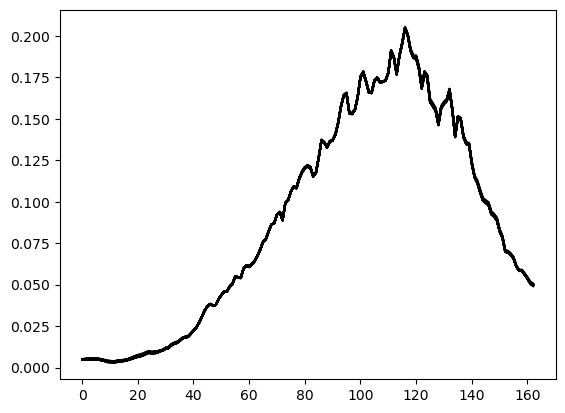

In [75]:
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    plt.plot(np.abs(ddd[292, :, 0]), color='k', alpha=i*(1./chunksize))
#    plt.plot(ddd[292, :, 0].imag, color='C0', alpha=i*(1./chunksize))

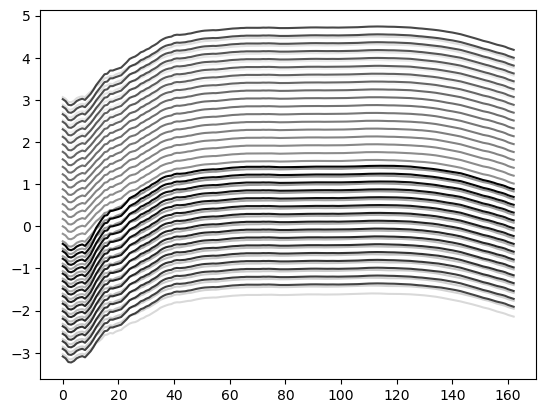

In [78]:
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    plt.plot(np.unwrap(np.angle(ddd[292, :, 0])), color='k', alpha=i*(1./chunksize))
#    plt.plot(ddd[292, :, 0].imag, color='C0', alpha=i*(1./chunksize))

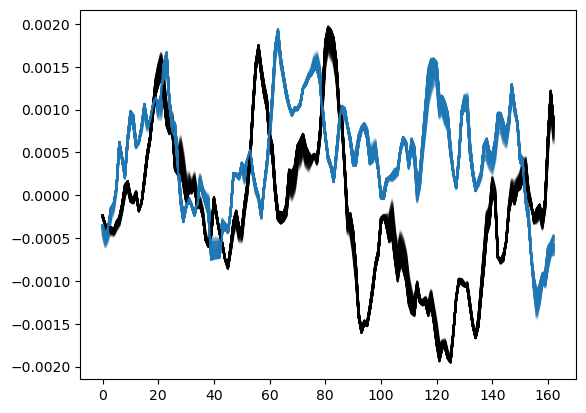

In [79]:
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    plt.plot(ddd[291, :, 0].real, color='k', alpha=i*(1./chunksize))
    plt.plot(ddd[291, :, 0].imag, color='C0', alpha=i*(1./chunksize))

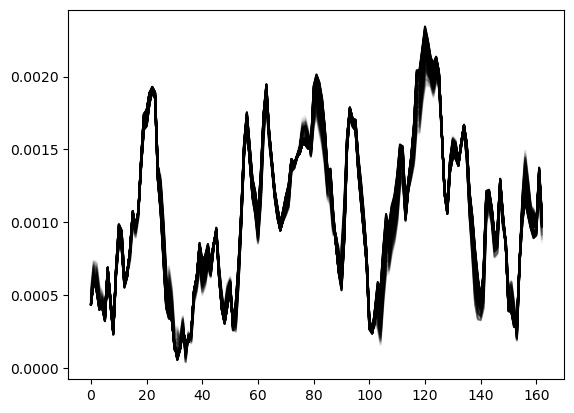

In [80]:
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    plt.plot(np.abs(ddd[291, :, 0]), color='k', alpha=i*(1./chunksize))
#    plt.plot(ddd[292, :, 0].imag, color='C0', alpha=i*(1./chunksize))

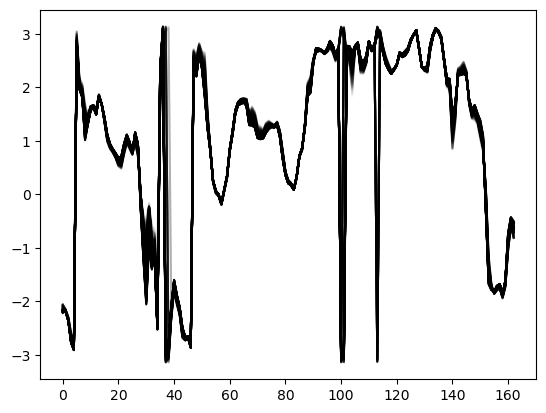

In [81]:
for i, ddd in enumerate(dd.reshape(chunksize, -1, len(chans), 2)):
    plt.plot(np.angle(ddd[291, :, 0]), color='k', alpha=i*(1./chunksize))

In [60]:
chnkmeta.antpos_enu[176] - chnkmeta.antpos_enu[18]

IndexError: index 176 is out of bounds for axis 0 with size 126

/tmp/ipykernel_85208/2287059135.py:3: RuntimeWarning: divide by zero encountered in power
  plt.plot(k, np.log10(1e-6*(k/0.2)**-2), color='r')


(-10.0, 3.0)

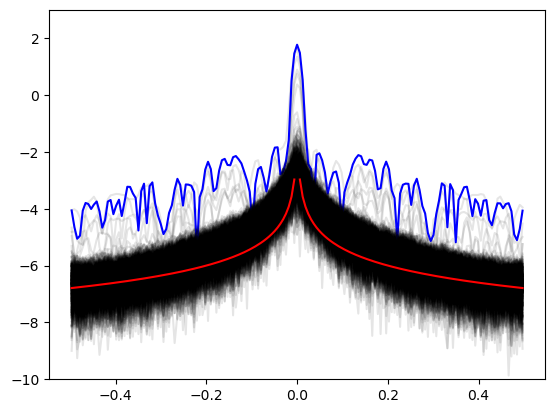

In [57]:
for i, blt in enumerate(dspecavg[1:]):
    plt.plot(k, np.fft.fftshift(np.log10(blt[:, 0])), alpha=1 if i==291 else 0.1, color='b' if i==291 else 'k')
plt.plot(k, np.log10(1e-6*(k/0.2)**-2), color='r')
plt.ylim(-10, 3)

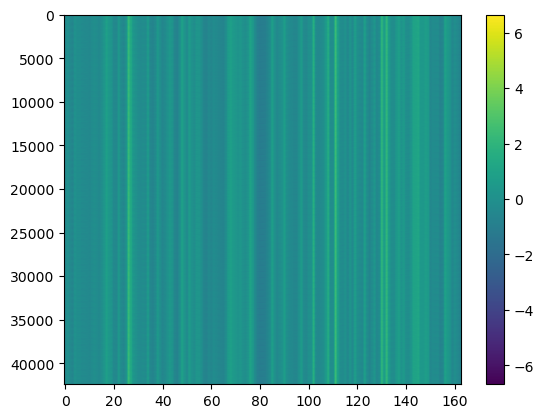

In [33]:
plt.imshow(np.log10(np.fft.fftshift(dspec[...,0]/dspec[1][...,0], axes=(1,))), aspect='auto')
plt.colorbar()

In [15]:
meta = FastUVH5Meta(rawfiles0[0])

In [18]:
meta.time_axis_faster_than_bls

False

In [21]:
meta.Ntimes

5760

In [19]:
meta.Nbls

707

In [40]:
meta.lsts[:5]

array([2.26265991e-07, 3.63835469e-04, 7.27447607e-04, 1.09105681e-03,
       1.45466601e-03])

In [39]:
chnkmeta.lsts

array([2.26265991e-07, 3.63835469e-04, 7.27447607e-04, 1.09105681e-03,
       1.45466601e-03, 1.81827815e-03, 2.18188735e-03, 2.54549656e-03,
       2.90910869e-03, 3.27271790e-03, 3.63632710e-03, 3.99993924e-03,
       4.36354844e-03, 4.72716058e-03, 5.09076978e-03, 5.45437899e-03,
       5.81799112e-03, 6.18160033e-03, 6.54520953e-03, 6.90882167e-03,
       7.27243087e-03, 7.63604007e-03, 7.99965221e-03, 8.36326141e-03,
       8.72687062e-03, 9.09048275e-03, 9.45409196e-03, 9.81770116e-03,
       1.01813133e-02, 1.05449225e-02, 1.09085317e-02, 1.12721438e-02,
       1.16357530e-02, 1.19993622e-02, 1.23629744e-02, 1.27265836e-02,
       1.30901957e-02, 1.34538049e-02, 1.38174141e-02, 1.41810263e-02,
       1.45446355e-02, 1.49082447e-02, 1.52718568e-02, 1.56354660e-02,
       1.59990752e-02, 1.63626874e-02, 1.67262966e-02, 1.70899058e-02,
       1.74535179e-02, 1.78171271e-02, 1.81807363e-02, 1.85443484e-02,
       1.89079577e-02, 1.92715669e-02, 1.96351790e-02, 1.99987882e-02,
      

## Mini Simulation to check bad baselines

In [36]:
from pyradiosky import SkyModel
import healpy
from vis_cpu import conversions
from pyuvdata import UVBeam
from vis_cpu.cpu import _validate_inputs, _wrangle_beams, _evaluate_beam_cpu, _get_antenna_vis
from astropy.constants import c

In [48]:
eorsky = SkyModel.from_skyh5("sky_models/eor/fch1123.skyh5")
eorsky.healpix_to_point()

In [49]:
eorsky.stokes.unit

Unit("Jy")

In [16]:
chnkmeta.antpairs[292]

(176, 18)

In [17]:
chnkmeta.antenna_names.index(f'HH{176}'), chnkmeta.antenna_names.index(f'HH{18}')

(111, 13)

In [18]:
antpos = chnkmeta.antpos_enu[[111, 13]]

In [19]:
lon, lat = eorsky.get_lon_lat()

In [74]:
freqs[chans[0]] - 3e6, freqs[chans[-1]]+3e6

(171118041.9921875, 196893432.6171875)

In [77]:
bigbeam = UVBeam.from_file("../hera-beams/NicolasFagnoniBeams/NF_HERA_Vivaldi_efield_beam.fits", freq_range=(freqs[chans[0]] - 4e6, freqs[chans[-1]]+4e6))
bigbeam.freq_interp_kind = 'cubic'

In [78]:
bigbeam.freq_array

array([[1.71e+08, 1.72e+08, 1.73e+08, 1.74e+08, 1.75e+08, 1.76e+08,
        1.77e+08, 1.78e+08, 1.79e+08, 1.80e+08, 1.81e+08, 1.82e+08,
        1.83e+08, 1.84e+08, 1.85e+08, 1.86e+08, 1.87e+08, 1.88e+08,
        1.89e+08, 1.90e+08, 1.91e+08, 1.92e+08, 1.93e+08, 1.94e+08,
        1.95e+08, 1.96e+08, 1.97e+08]])

In [28]:
beam.freq_array

array([[1.84005737e+08]])

In [50]:
freq = freqs[1123]
lsts = [0.0]
latitude = -30.7215 * np.pi / 180.0
eq2tops = np.array([conversions.eci_to_enu_matrix(lst, latitude) for lst in lsts])
crd_eq = conversions.point_source_crd_eq(lon.rad, lat.rad)
I_sky = eorsky.stokes[0,0]
beam_list = [beam]
precision=2
polarized=True
beam_idx=np.array([0,0], dtype=int)
beam_spline_opts={'kx': 3, 'ky': 3}

nbeam=1

In [51]:
nax, nfeed, nant, ntimes = _validate_inputs(
    precision, polarized, antpos, eq2tops, crd_eq, I_sky
)

if precision == 1:
    real_dtype = np.float32
    complex_dtype = np.complex64
else:
    real_dtype = np.float64
    complex_dtype = np.complex128

# beam_list, nbeam, beam_idx = _wrangle_beams(
#     beam_idx, beam_list, polarized, nant, freq
# )


In [83]:

# Intensity distribution (sqrt) and antenna positions. Does not support
# negative sky. Factor of 0.5 accounts for splitting Stokes I between
# polarization channels
Isqrt = np.sqrt(0.5 * I_sky).astype(real_dtype)
antpos = antpos.astype(real_dtype)


# Zero arrays: beam pattern, visibilities, delays, complex voltages
simvis = np.full((len(chans), ntimes, nfeed * nant, nfeed * nant), 0.0, dtype=complex_dtype)
#logger.info(f"Visibility Array takes {vis.nbytes/1024**2:.1f} MB")

crd_eq = crd_eq.astype(real_dtype)

In [84]:
# Loop over time samples
for jf, freq in enumerate(freqs[chans]):
    print(f"doing freq {jf}")
    ang_freq = real_dtype(2.0 * np.pi * freq)
    beam = bigbeam.interp(freq_array=np.array([freq]), new_object=True, reuse_spline=True) 
    beam_list = [beam]
    
    for t, eq2top in enumerate(eq2tops.astype(real_dtype)):
        # Dot product converts ECI cosines (i.e. from RA and Dec) into ENU
        # (topocentric) cosines, with (tx, ty, tz) = (e, n, u) components
        # relative to the center of the array
        tx, ty, tz = crd_top = np.dot(eq2top, crd_eq)
        above_horizon = tz > 0
        tx = tx[above_horizon]
        ty = ty[above_horizon]
        nsrcs_up = len(tx)
        isqrt = Isqrt[above_horizon]

        A_s = np.full((nax, nfeed, nbeam, nsrcs_up), 0.0, dtype=complex_dtype)

        _evaluate_beam_cpu(
            A_s,
            beam_list,
            tx,
            ty,
            polarized,
            freq,
            check=t == 0,
            spline_opts=beam_spline_opts,
        )
        A_s = A_s.transpose((1, 2, 0, 3))  # Now (Nfeed, Nbeam, Nax, Nsrc)

        # Calculate delays, where tau = (b * s) / c
        tau = np.dot(antpos / c.value, crd_top[:, above_horizon])

        v = _get_antenna_vis(
            A_s, ang_freq, tau, isqrt, beam_idx, nfeed, nant, nax, nsrcs_up
        )

        # Compute visibilities using product of complex voltages (upper triangle).
        simvis[jf, t] = v.conj().dot(v.T)

simvis.shape = (len(chans), ntimes, nfeed, nant, nfeed, nant)

doing freq 0
doing freq 1
doing freq 2
doing freq 3
doing freq 4
doing freq 5
doing freq 6
doing freq 7
doing freq 8
doing freq 9
doing freq 10
doing freq 11
doing freq 12
doing freq 13
doing freq 14
doing freq 15
doing freq 16
doing freq 17
doing freq 18
doing freq 19
doing freq 20
doing freq 21
doing freq 22
doing freq 23
doing freq 24
doing freq 25
doing freq 26
doing freq 27
doing freq 28
doing freq 29
doing freq 30
doing freq 31
doing freq 32
doing freq 33
doing freq 34
doing freq 35
doing freq 36
doing freq 37
doing freq 38
doing freq 39
doing freq 40
doing freq 41
doing freq 42
doing freq 43
doing freq 44
doing freq 45
doing freq 46
doing freq 47
doing freq 48
doing freq 49
doing freq 50
doing freq 51
doing freq 52
doing freq 53
doing freq 54
doing freq 55
doing freq 56
doing freq 57
doing freq 58
doing freq 59
doing freq 60
doing freq 61
doing freq 62
doing freq 63
doing freq 64
doing freq 65
doing freq 66
doing freq 67
doing freq 68
doing freq 69
doing freq 70
doing freq 71
do

In [43]:
v.shape

(4, 196608)

In [89]:
vis.shape

(60, 706, 2, 163)

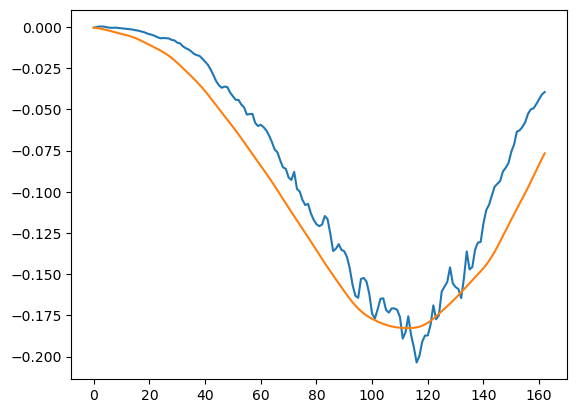

In [93]:
plt.plot(vis[0, 291, 0, :].real)
plt.plot(simvis[:, 0, 0, 0, 0, 1].real / 5000)


In [96]:
pp = np.polyfit(np.arange(163), simvis[:, 0, 0, 0, 0, 1].real, deg=10)

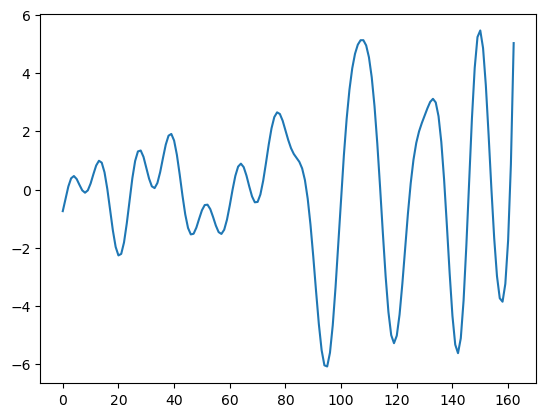

In [100]:
plt.plot(simvis[:, 0, 0, 0, 0, 1].real - np.polyval(pp,np.arange(163)))

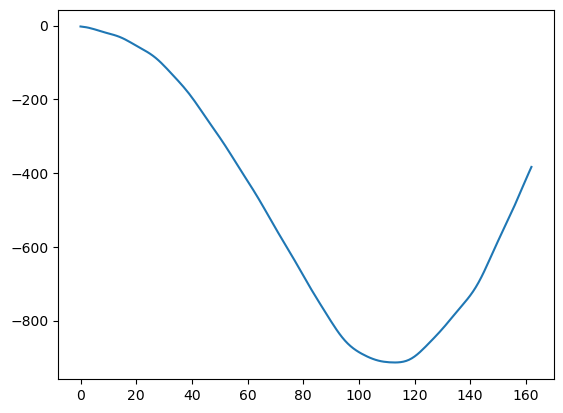

In [88]:
plt.plot(simvis[:, 0, 0, 0, 0, 1].real)


In [85]:
simvis.shape

(163, 1, 2, 2, 2, 2)

In [54]:
simvis

array([[[[[ 4.46142054e+03  +0.j        ,
           -6.90731694e+02+972.16221005j],
          [ 3.70250725e+00 -58.25256014j,
            2.48029844e+01 +75.73185344j]],

         [[-6.90731694e+02-972.16221005j,
            4.46142054e+03  +0.j        ],
          [ 5.43439022e+00 -48.74120912j,
            3.70250725e+00 -58.25256014j]]],


        [[[ 3.70250725e+00 +58.25256014j,
            5.43439022e+00 +48.74120912j],
          [ 4.45785412e+03  +0.j        ,
           -6.39899626e+02+972.7960281j ]],

         [[ 2.48029844e+01 -75.73185344j,
            3.70250725e+00 +58.25256014j],
          [-6.39899626e+02-972.7960281j ,
            4.45785412e+03  +0.j        ]]]]])

In [101]:
chans

array([1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052,
       1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063,
       1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074,
       1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085,
       1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096,
       1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107,
       1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118,
       1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129,
       1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140,
       1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151,
       1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162,
       1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173,
       1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184,
       1185, 1186, 1187, 1188, 1189, 1190, 1191, 11

In [102]:
import md5

ModuleNotFoundError: No module named 'md5'

In [103]:
from hashlib import md5

In [105]:
md5?

Signature: md5(string=b'', *, usedforsecurity=True)
Docstring: Returns a md5 hash object; optionally initialized with a string
Type:      builtin_function_or_method

In [108]:
x = md5(str([1,2,3]).encode())

In [109]:
x.hexdigest()

'49a5a960c5714c2e29dd1a7e7b950741'

In [110]:
badbls

array([109, 123, 124, 251, 289, 291])

In [114]:
x = np.genfromtxt("config_files/array_layouts/array_layout_hera_350.txt")

In [115]:
x.dtype

dtype('float64')

In [116]:
x.shape

(350, 4)

In [138]:
idx = np.argsort(x[:, 0])

In [139]:
y = x[idx]

In [141]:
y[308]

array([3.08000000e+02, 5.40901600e+05, 6.60131519e+06, 1.05031000e+03])

In [142]:
x[0]

array([3.08000000e+02, 5.40901600e+05, 6.60131519e+06, 1.05031000e+03])

In [123]:
y = np.sort(x, axis=0)

In [128]:
y[308]

array([3.0800000e+02, 5.4107680e+05, 6.6012899e+06, 1.0523600e+03])

In [126]:
x[0]

array([3.08000000e+02, 5.40901600e+05, 6.60131519e+06, 1.05031000e+03])